In [1]:
%run divvy_download.py

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
directory = "./extracted_files_test"

dataframes_number = {}
dataframes_divvy = {}
i = 0
j = 0
for root, dirs, files in os.walk(directory):
    for filename in files:
        file_path = os.path.join(root, filename)
        #print(f"File: {file_path}")
        if filename.endswith('tripdata.csv'): #or filename.startswith('Divvy_Trips'):  
            #print(filename)
            try:
                df = pd.read_csv(file_path)
                dataframes_number[i] = df
                i += 1
            except:
                pass
            
        if filename.startswith('Divvy_Trips'):
            #print(filename)           
            try:
                df = pd.read_csv(file_path)
                dataframes_divvy[j] = df
                j += 1
            except:
                pass

/var/folders/qx/bdlxtnn15xg42mxf3d1962000000gn/T/ipykernel_32980/4161177170.py:23: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [4]:
def merge_dfs(dataframes):
    merged = dataframes[0]
    for i in range(1,len(dataframes)):
        merged = pd.concat([merged,dataframes[i]], axis=0, ignore_index=True)
    return merged

In [5]:
merged_number = merge_dfs(dataframes_number)   

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

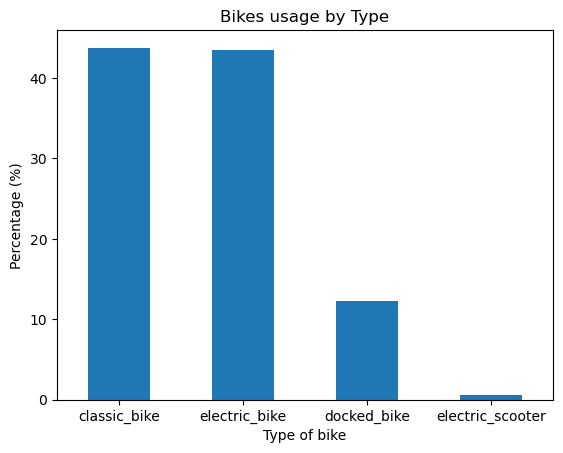

In [7]:
rideable_type_percent = merged_number['rideable_type'].value_counts(normalize=True) * 100
rideable_type_percent.plot(kind='bar',rot=0)

plt.title('Bikes usage by Type')
plt.xlabel('Type of bike')
plt.ylabel('Percentage (%)')
plt.show()

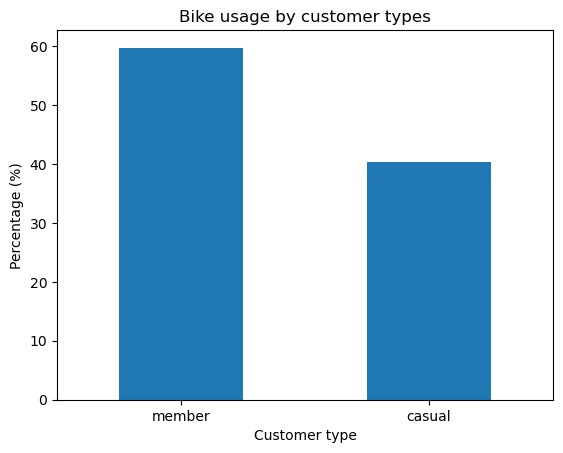

In [8]:
member_casual_percent = merged_number['member_casual'].value_counts(normalize=True) * 100
member_casual_percent.plot(kind='bar',rot=0)

plt.title('Bike usage by customer types')
plt.xlabel('Customer type')
plt.ylabel('Percentage (%)')
plt.show()

In [9]:
df = merged_number

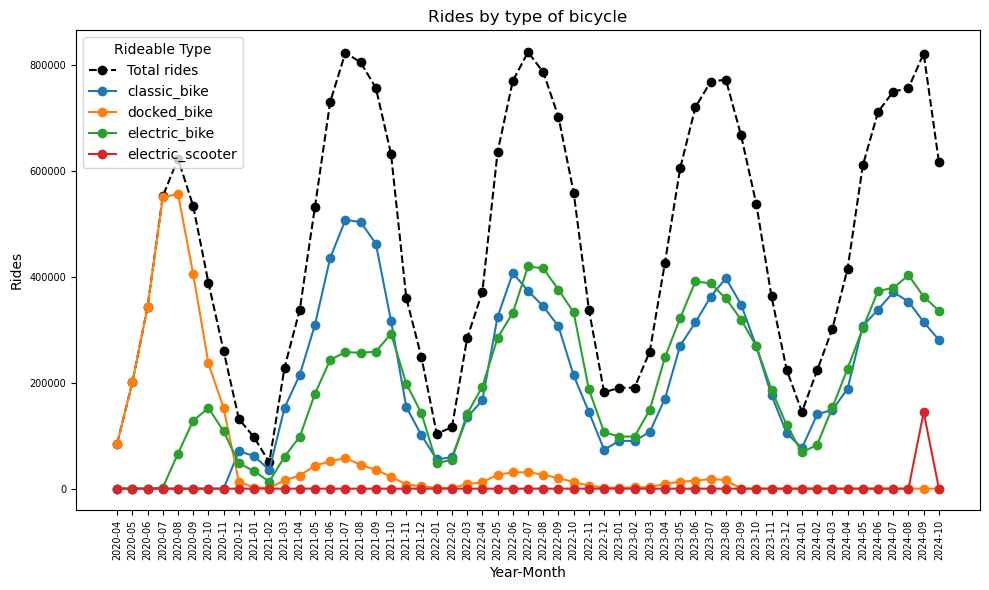

In [10]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Create a new column that represents the 'year-month' combination
df['year_month'] = df['started_at'].dt.to_period('M')

# Count the number of occurrences in each 'year-month'
incidences_by_type = df.groupby(['year_month', 'rideable_type']).size().unstack(fill_value=0)
total_incidences = incidences_by_type.sum(axis=1)

plt.figure(figsize=(10, 6))

plt.plot(incidences_by_type.index.astype(str), total_incidences, 
         marker='o', label='Total rides', color='black', linestyle='--')

# Plot each category
for rideable_type in incidences_by_type.columns:
    plt.plot(incidences_by_type.index.astype(str), incidences_by_type[rideable_type], 
             marker='o', label=rideable_type)

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Rides')
plt.title('Rides by type of bicycle')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.tick_params(labelsize=7)
# Add a legend to differentiate rideable types
plt.legend(title="Rideable Type")

plt.tight_layout()

plt.show()


In [11]:
df['year_month_day'] = df['started_at'].dt.to_period('D')
incidences_by_type_day = df.groupby(['year_month_day', 'rideable_type']).size().unstack(fill_value=0)
total_incidences_day = incidences_by_type_day.sum(axis=1)

In [12]:
df['hour'] = df['started_at'].dt.to_period('H')

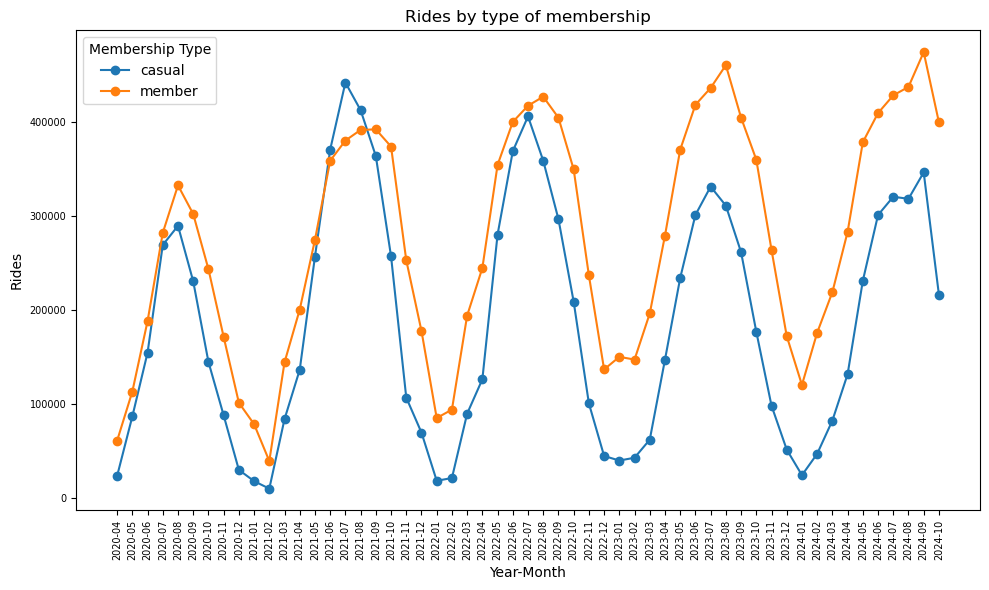

In [13]:
membs_by_type = df.groupby(['year_month', 'member_casual']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))

for rideable_type in membs_by_type.columns:
    plt.plot(membs_by_type.index.astype(str), membs_by_type[rideable_type], 
             marker='o', label=rideable_type)

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Rides')
plt.title('Rides by type of membership')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
#plt.gca().set_xticks(incidences_by_type.index.to_timestamp()[::3].to_pydatetime())
plt.tick_params(labelsize=7)
# Add a legend to differentiate rideable types
plt.legend(title="Membership Type")

plt.tight_layout()

plt.show()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Streeter Dr & Grand Ave'),
  Text(1, 0, 'Michigan Ave & Oak St'),
  Text(2, 0, 'Clark St & Elm St'),
  Text(3, 0, 'Wells St & Concord Ln'),
  Text(4, 0, 'Millennium Park')])

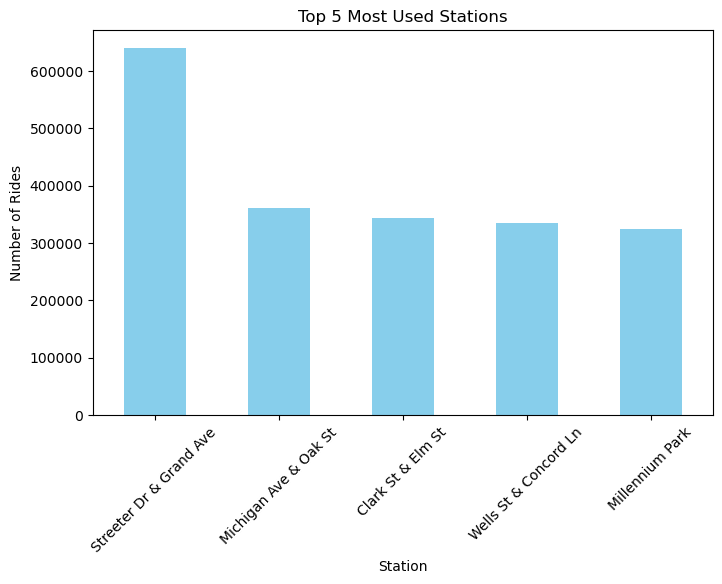

In [14]:
combined_stations = pd.concat([df['start_station_name'], df['end_station_name']])

station_counts = combined_stations.value_counts()
station_counts_5 = combined_stations.value_counts().nlargest(5)

# Plot the top 5 stations as a bar plot
plt.figure(figsize=(8, 5))
station_counts_5.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Station')
plt.ylabel('Number of Rides')
plt.title('Top 5 Most Used Stations')
plt.xticks(rotation=45)



In [15]:
df['ride_time'] = df['ended_at'] - df['started_at']
df['ride_time'] = pd.to_timedelta(df['ride_time'])

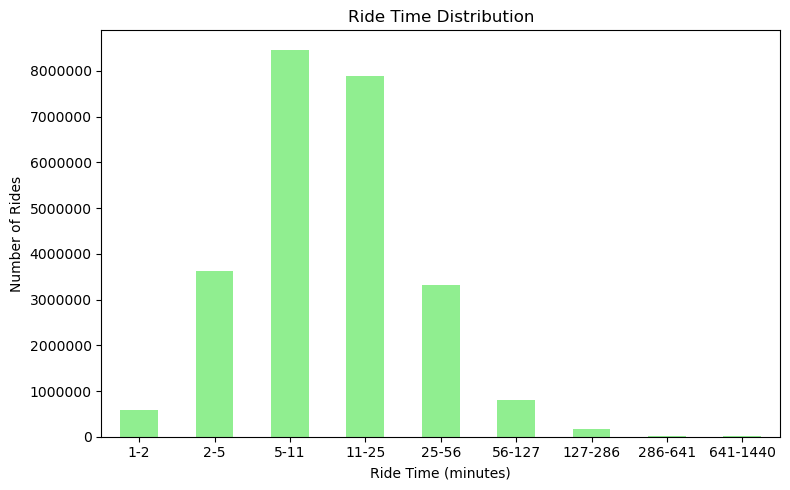

In [16]:
df['ride_time_minutes'] = df['ride_time'].dt.total_seconds() / 60

# Bin the ride times into 10-minute intervals
#bins = range(0, 240, 10)
bins = np.logspace(np.log10(1), np.log10(1440), num=10)

df['ride_time_bin'] = pd.cut(df['ride_time_minutes'], bins=bins)

# Count the number of rides in each bin
ride_time_counts = df['ride_time_bin'].value_counts().sort_index()
bin_labels = [f'{int(interval.left)}-{int(interval.right)}' for interval in ride_time_counts.index]
# Plot the counts as a bar plot
plt.figure(figsize=(8, 5))
ride_time_counts.plot(kind='bar', color='lightgreen')

# Add labels and title
plt.xlabel('Ride Time (minutes)')
plt.ylabel('Number of Rides')
plt.title('Ride Time Distribution')

# Rotate x-axis labels for better readability
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels)
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
plt.show()

In [17]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Apply the function to calculate the distance and store it in a new column
df['distance_km'] = haversine(df['start_lat'], df['start_lng'], df['end_lat'], df['end_lng'])

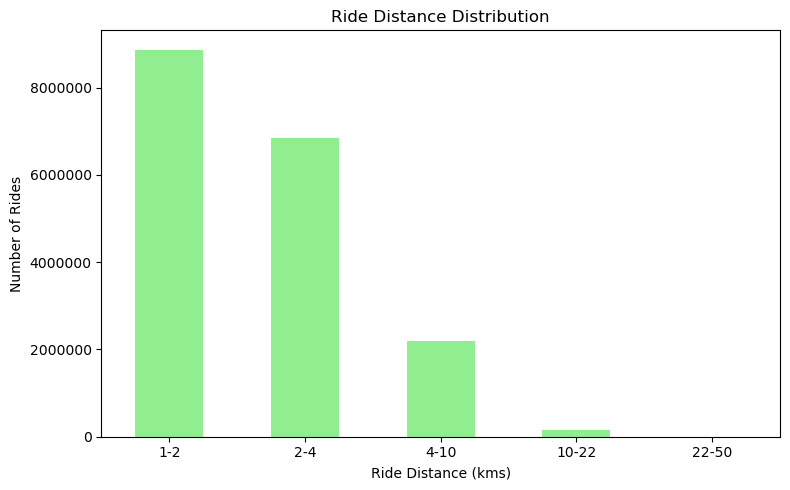

In [18]:
#bins = range(0, 100, 10)
bins = np.logspace(np.log10(1), np.log10(50), num=6)

df['ride_distance_bin'] = pd.cut(df['distance_km'], bins=bins)

ride_distance_counts = df['ride_distance_bin'].value_counts().sort_index()
bin_labels = [f'{int(interval.left)}-{int(interval.right)}' for interval in ride_distance_counts.index]
# Plot the counts as a bar plot
plt.figure(figsize=(8, 5))
ride_distance_counts.plot(kind='bar', color='lightgreen')

# Add labels and title
plt.xlabel('Ride Distance (kms)')
plt.ylabel('Number of Rides')
plt.title('Ride Distance Distribution')

# Rotate x-axis labels for better readability
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels)
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distance vs time')

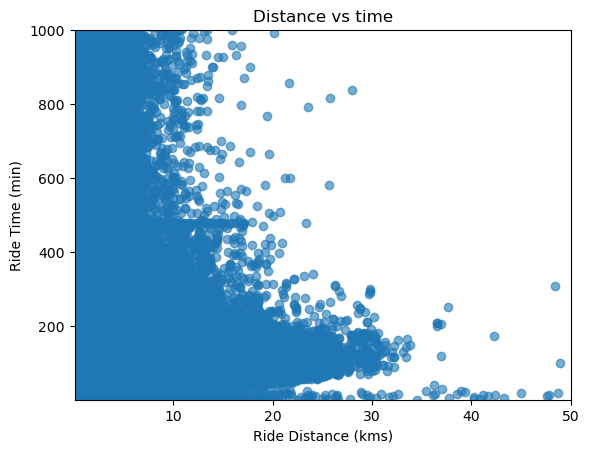

In [19]:
plt.scatter(df['distance_km'], df['ride_time_minutes'], alpha=0.6)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim([0.1,50])
plt.ylim([1,1000])
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: int(x)))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: int(x)))

plt.xlabel('Ride Distance (kms)')
plt.ylabel('Ride Time (min)')
plt.title('Distance vs time')
#plt.ylim([1,600])

In [20]:
station_counts = combined_stations.value_counts().reset_index()
station_counts.columns = ['start_station_name', 'count']

# Step 2: For each station, get the mode of latitude and longitude
unique_stations = df.groupby('start_station_name').agg({
    'start_lat': lambda x: x.mode()[0],  # Get mode for latitude
    'start_lng': lambda x: x.mode()[0]  # Get mode for longitude
}).reset_index()

# Step 3: Merge the counts with the unique stations data
station_summary_df = pd.merge(station_counts, unique_stations, on='start_station_name', how='left')

In [21]:
station_summary_df = station_summary_df.dropna()

In [22]:
from geopy.geocoders import ArcGIS
import folium

import ipywidgets as widgets
from IPython.display import display, clear_output

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="location_details")

location = geolocator.geocode("Chicago")
print((location.latitude, location.longitude))

mymap = folium.Map(location=[location.latitude, location.longitude], zoom_start=12)

#for station in station_counts.items():

#   coef = station[1]
#    popup_info = station[0]+'\n'+str(coef)
        
#    folium.Circle(location=[df[df['start_station_name'] == station[0]].start_lat.mode()[0],df[df['start_station_name'] == station[0]].start_lng.mode()[0]],radius=coef/1000,popup=popup_info,color="blue",fill=True,fill_color="blue",fill_opacity=0.4).add_to(mymap)


for index, row in station_summary_df.iterrows():
    coef = row['count']/1000
    popup_info = row['start_station_name']+'\n'+str(row['count'])        
    folium.Circle(location=[row['start_lat'],row['start_lng']],radius=coef,popup=popup_info,color="blue",fill=True,fill_color="blue",fill_opacity=0.4).add_to(mymap)
  
display(mymap)

(41.8755616, -87.6244212)


In [23]:
# Convert the 'started_at' column to datetime if it's not already
df['started_at'] = pd.to_datetime(df['started_at'])

# Extract only the hour and format it as 'HH:00'
df['hour'] = df['started_at'].dt.strftime('%H:00')

# Count the number of incidences for each hour
hourly_counts = df['hour'].value_counts().sort_index()

In [24]:
theta = np.linspace(0.0, 2*np.pi, 12, endpoint=False)
radii = list(hourly_counts)
base_width = 2*np.pi /24
width = base_width

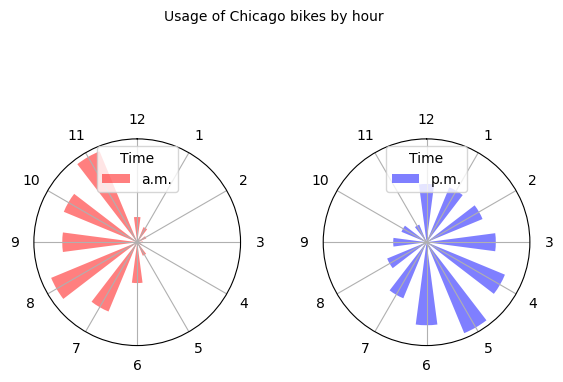

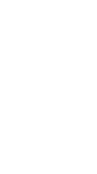

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'})
plt.suptitle('Usage of Chicago bikes by hour', fontsize=10)
fig.subplots_adjust(wspace=0.4)
plt.figure(figsize=(1,2))
plt.axis('off')

ax1.set_theta_direction(-1)
ax1.set_theta_offset(np.pi / 2.0)
ax1.bar(theta, radii[0:12], bottom=0.0, width=width, color='r', alpha=0.5)
ax1.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
ax1.set_yticks([])
ax1.set_xticklabels([12, *range(1, 12)])
ax1.legend(['a.m.'], title='Time', loc='upper center');

ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2.0)
ax2.bar(theta, radii[12:24], bottom=0.0, width=width, color='b', alpha=0.5)
ax2.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
ax2.set_yticks([])
ax2.set_xticklabels([12, *range(1, 12)])
ax2.legend(['p.m.'], title='Time', loc='upper center');

plt.show()

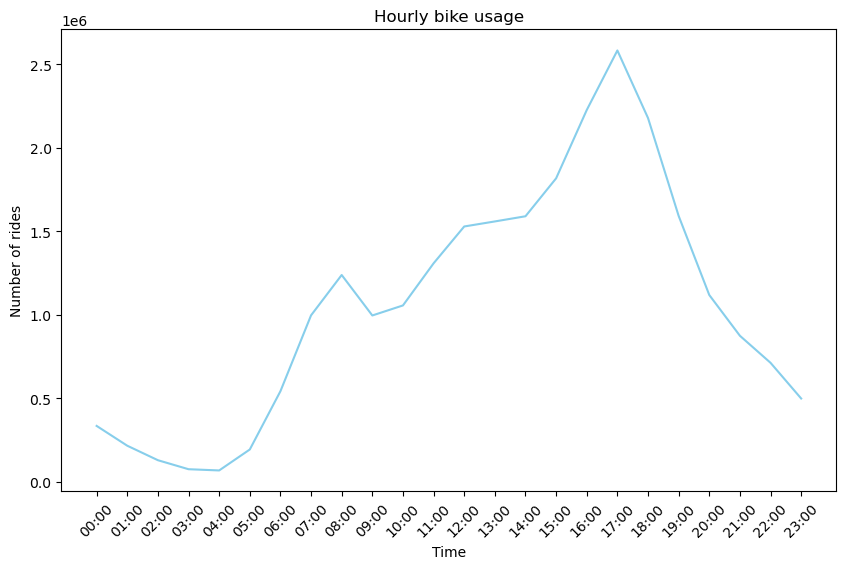

In [26]:
hourly_counts.plot(figsize=(10, 6), color='skyblue')
plt.title('Hourly bike usage')
plt.xlabel('Time')
plt.ylabel('Number of rides')
plt.xticks(ticks=range(len(hourly_counts)), labels=hourly_counts.index, rotation=45);

In [27]:
df['started_at'] = pd.to_datetime(df['started_at'])

# Extract the day of the week and set the correct order
df['day_of_week'] = pd.Categorical(df['started_at'].dt.day_name(), 
                                   categories=["Monday", "Tuesday", "Wednesday", "Thursday", 
                                               "Friday", "Saturday", "Sunday"], 
                                   ordered=True)

# Count occurrences of each day of the week, now in the correct order
day_counts = df['day_of_week'].value_counts().sort_index()

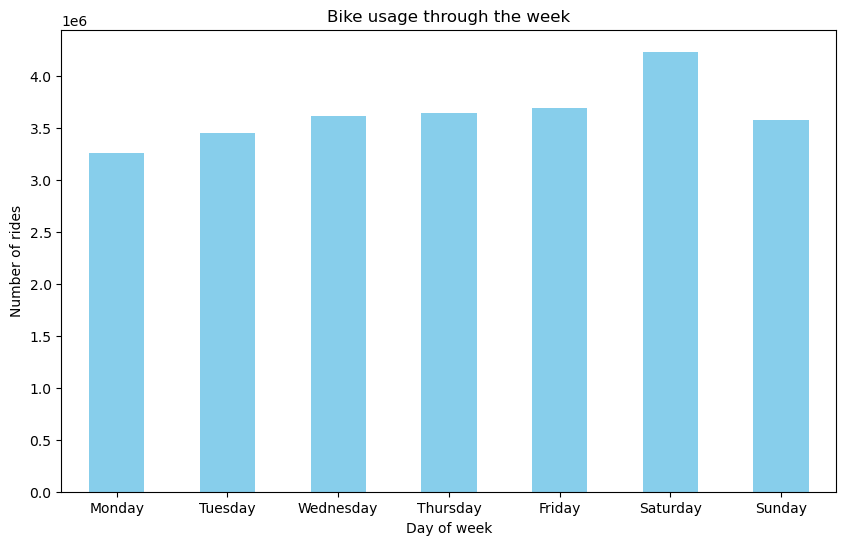

In [28]:
day_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Bike usage through the week')
plt.xlabel('Day of week')
plt.ylabel('Number of rides')
plt.xticks(rotation=0);

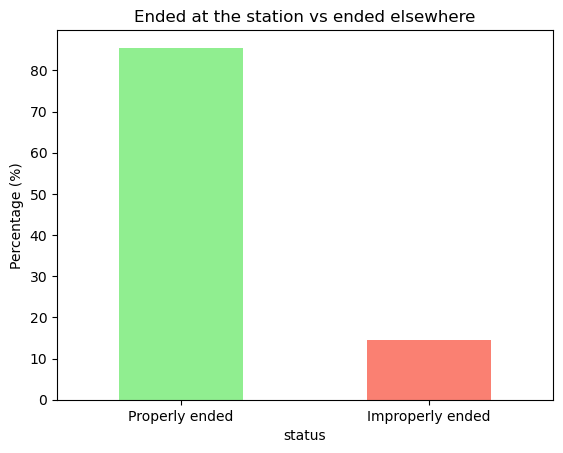

In [29]:
# Calculate the counts of NaN and non-NaN values
total_count = len(df['end_station_id'])
nan_count = (df['end_station_id'].isna().sum() / total_count) * 100
not_nan_count = (df['end_station_id'].notna().sum() / total_count) * 100

# Create a DataFrame for plotting
counts_df = pd.DataFrame({
    'status': ['Properly ended', 'Improperly ended'],
    'count': [not_nan_count, nan_count]
})

# Plot the bars
counts_df.plot(kind='bar', x='status', y='count', legend=False, color=['lightgreen', 'salmon'])
plt.xticks(rotation=0)
plt.ylabel('Percentage (%)')
plt.title('Ended at the station vs ended elsewhere');

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [31]:
monthly_data = df['year_month'].value_counts().sort_index()

In [32]:
def check_stationarity(timeseries): 
    # Perform the Dickey-Fuller test 
    result = adfuller(timeseries, autolag='AIC') 
    p_value = result[1] 
    print(f'ADF Statistic: {result[0]}') 
    print(f'p-value: {p_value}') 
    print('Stationary' if p_value < 0.05 else 'Non-Stationary') 
  
  
check_stationarity(total_incidences)

ADF Statistic: -3.2770578485854234
p-value: 0.0159356579572306
Stationary


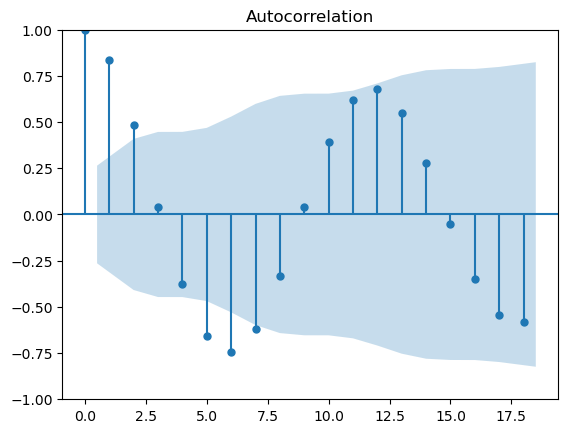

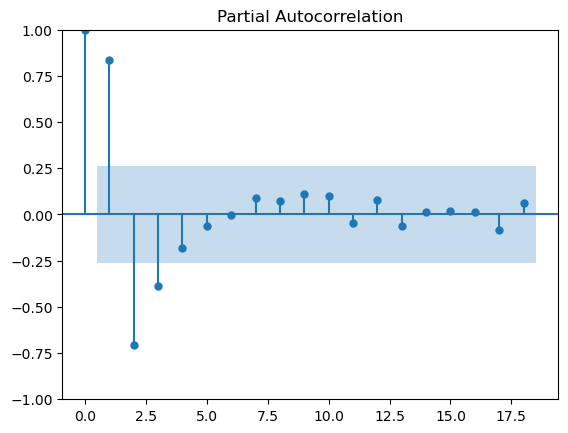

In [33]:
# Plot ACF and PACF 
plot_acf(total_incidences) 
plot_pacf(total_incidences) 
plt.show()

In [34]:
def time_prediction(parameter, offset, to_plot, title):

    p, d, q = 1, 1, 1
    P, D, Q, s = 1, 1, 1, offset  # Assuming monthly seasonality 
  
    # Fit the SARIMA model 
    model = SARIMAX(parameter, order=(p, d, q), seasonal_order=(P, D, Q, s)) 
    results = model.fit(disp=False) 

    # Forecast future values 
    forecast_periods = 12  # Forecast the next 12 months 
    forecast = results.get_forecast(steps=forecast_periods) 
    forecast_mean = forecast.predicted_mean 
    forecast_ci = forecast.conf_int() 
  
    # Plot the forecast 
    plt.figure(figsize=(12, 6)) 
    to_plot.plot(label='Observed') 
    forecast_mean.plot(label='Forecast', color='red') 
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink') 
    plt.title(title) 
    plt.xlabel("Time") 
    plt.ylabel("Number of rides") 
    plt.legend() 
    plt.show()
    
    return forecast_mean 

/Users/victor/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


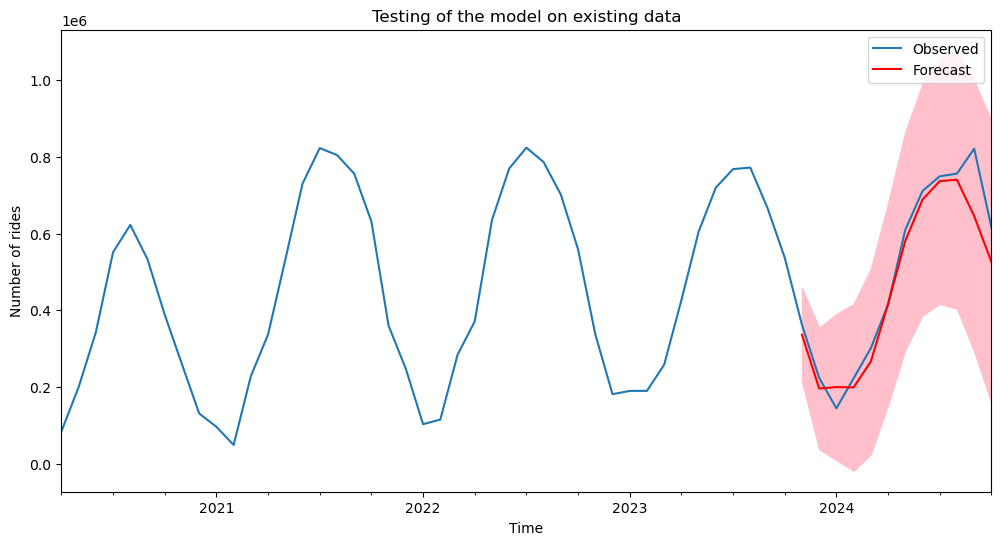

MAE: 42854.23806631796
MSE: 3911082566.652991
R2: 0.927159975636868


In [35]:
forecast_mean = time_prediction(total_incidences[:-12],12, total_incidences, "Testing of the model on existing data")

observed = total_incidences[-12:] 
mae = mean_absolute_error(observed, forecast_mean) 
mse = mean_squared_error(observed, forecast_mean) 
r2 = r2_score(observed, forecast_mean)
print(f'MAE: {mae}') 
print(f'MSE: {mse}')
print(f'R2: {r2}')

/Users/victor/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


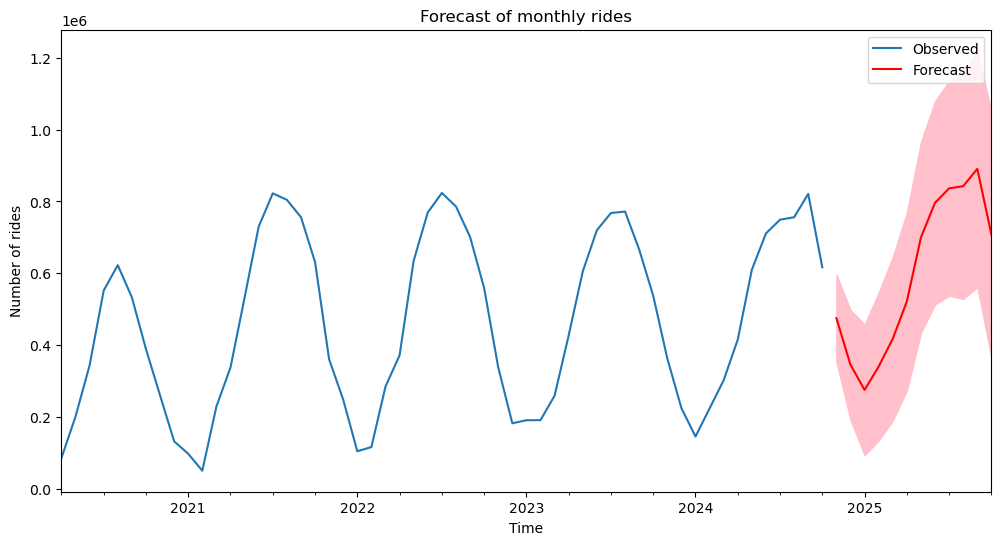

In [36]:
forecast_sarima = time_prediction(total_incidences, 12, total_incidences, "Forecast of monthly rides")


In [37]:
#df.to_csv('df.tsv', sep='\t')

In [38]:
total_incidences.index = total_incidences.index.strftime('%Y-%m')
total_incidences.to_csv('total_incidences.tsv', sep='\t')

In [39]:
#importing scikit-learn packages

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier

In [40]:
df['year'] = pd.to_datetime(df['started_at']).dt.year
df['month'] = pd.to_datetime(df['started_at']).dt.month


In [41]:
df_xgboost = df[df.ride_time_minutes > 0].groupby('year_month').agg(
    ride_id_count=('ride_id', 'count'),  # Count of 'ride_id'
    year = ('year','max'),
    month = ('month','max')
).reset_index()

df_xgboost['ride_id_count_lastmonth'] = df_xgboost['ride_id_count'].shift(1)
#df_xgboost['avg_ride_time_lastmonth'] = df_xgboost['avg_ride_time'].shift(1)
#df_xgboost['avg_distance_lastmonth'] = df_xgboost['avg_distance'].shift(1)

In [42]:
df_xgboost = df_xgboost.drop(columns=['year_month'], axis=1)
df_xgboost = df_xgboost.iloc[1:]
y = df_xgboost['ride_id_count']
X = df_xgboost.drop(columns=['ride_id_count'], axis=1)


In [43]:
my_model_1 = XGBRegressor(random_state=0, max_depth=3, n_estimators=100, learning_rate=0.3, objective='count:poisson') 

kfold = KFold(n_splits=5)
results_1 = cross_val_score(my_model_1, X, y, cv=kfold, error_score='raise')

print("Accuracy %.2f%% with a standard deviation %.2f%%" % (results_1.mean()*100, results_1.std()*100))

Accuracy 89.70% with a standard deviation 7.29%


In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=1) 


In [45]:
param_grid = {'max_depth':[3, 4, 5],  
              'n_estimators':[50, 100, 200, 300], 
              'learning_rate':[0.005, 0.01, 0.05, 0.1, 0.3, 0.5],
              }  

grid = GridSearchCV(XGBRegressor(random_state=1, objective='count:poisson'), param_grid, refit = True, n_jobs=-1) 
grid.fit(X_train, y_train)
print(grid.best_params_) 
grid_pred = grid.predict(X_valid)

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}


In [46]:
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean absolute error: %s" % mean_absolute_error(y_valid, grid_pred))
print("R2 score: %s" % r2_score(y_valid, grid_pred))

Mean absolute error: 51876.98082386364
R2 score: 0.8405330386420317


In [47]:
last_row = df_xgboost.iloc[-1]

# Initialize the new DataFrame for predictions
forecast_data = []

# Extract initial values
current_month = last_row['month']+1
current_year = last_row['year']
current_ride_id_count = last_row['ride_id_count']  # Use as starting value for ride_id_count_lastmonth

# Generate predictions for the next 12 months
for _ in range(12):
    # Prepare the input features for prediction
    input_features = pd.DataFrame({
        'year': [current_year],
        'month': [current_month],
        'ride_id_count_lastmonth': [current_ride_id_count]
    })
    
    # Predict the ride_id_count for the current month
    predicted_ride_id_count = grid.predict(input_features)[0]  # Extract the prediction value
    
    # Append the forecasted data
    forecast_data.append({
        'year': current_year,
        'month': current_month,
        'ride_id_count_lastmonth': current_ride_id_count,
        'ride_id_count': predicted_ride_id_count
    })
    
    # Update the values for the next iteration
    current_ride_id_count = predicted_ride_id_count  # Use the current prediction for the next month's lastmonth value
    current_month += 1
    if current_month > 12:  # Increment the year if the month exceeds 12
        current_month = 1
        current_year += 1

# Create a DataFrame from the forecasted data
forecast_df = pd.DataFrame(forecast_data)

# Display the result
print(forecast_df)

      year  month  ride_id_count_lastmonth  ride_id_count
0   2024.0   11.0            616246.000000  363056.187500
1   2024.0   12.0            363056.187500  226568.578125
2   2025.0    1.0            226568.578125  156959.671875
3   2025.0    2.0            156959.671875  223120.843750
4   2025.0    3.0            223120.843750  334639.468750
5   2025.0    4.0            334639.468750  510068.156250
6   2025.0    5.0            510068.156250  607634.250000
7   2025.0    6.0            607634.250000  710754.937500
8   2025.0    7.0            710754.937500  749067.000000
9   2025.0    8.0            749067.000000  755837.437500
10  2025.0    9.0            755837.437500  820823.187500
11  2025.0   10.0            820823.187500  616232.062500


In [48]:
forecast_df['time'] = forecast_df['year'].astype(int).astype(str) + '-' + forecast_df['month'].astype(int).astype(str).str.zfill(2)
#total_incidences.index = total_incidences.index.strftime('%Y-%m')
forecast_sarima.index = forecast_sarima.index.strftime('%Y-%m')


<Figure size 1200x600 with 0 Axes>

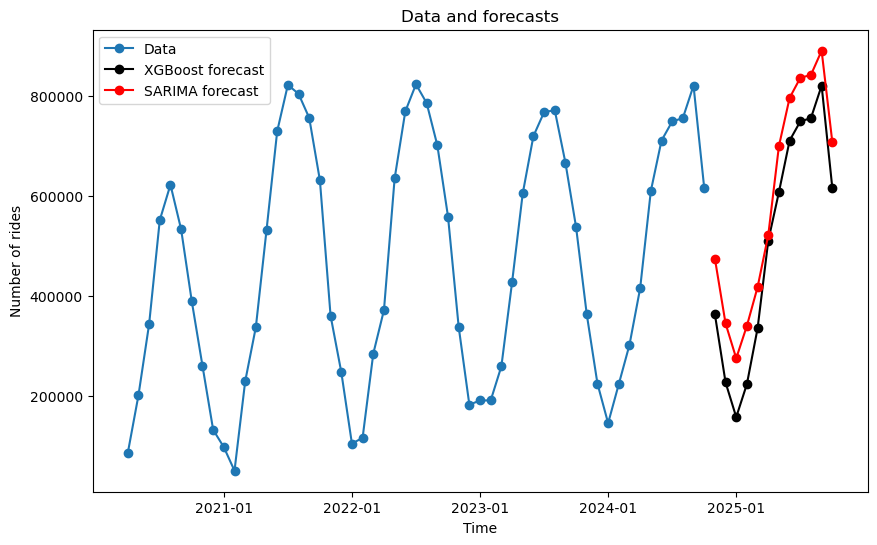

In [49]:
plt.figure(figsize=(12, 6)) 

year_ticks = [label for label in total_incidences.index if '-01' in label] + ['2025-01']
# Plot the total incidences
plt.figure(figsize=(10, 6))
plt.plot(total_incidences.index, total_incidences.values, marker='o', linestyle='-', label='Data')

plt.plot(forecast_df['time'], forecast_df['ride_id_count'], color='black', marker='o', linestyle='-', label='XGBoost forecast')
plt.plot(forecast_sarima.index, forecast_sarima.values, color = 'red', marker='o', linestyle='-', label='SARIMA forecast')
plt.title("Data and forecasts") 
plt.xticks(year_ticks)
plt.xlabel("Time") 
plt.ylabel("Number of rides") 
plt.legend() 
plt.show()